In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image
from tqdm import tqdm
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

USE_GPU = True
dtype = torch.float32 # We will be using float

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 1000
print('using device:', device)

using device: cuda


In [2]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import torch

from sklearn.preprocessing import LabelEncoder

# Define a transform without normalization
transform = transforms.Compose([
    transforms.ToTensor()  # Convert NumPy array to PyTorch tensor
])

class NumpyDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X  # Keep as NumPy array
        self.transform = transform  # Store the transform
        
        # Convert string labels into numeric using LabelEncoder
        self.label_encoder = LabelEncoder()
        self.Y = [str(y[0]) for y in Y]  # Ensure Y is a list of strings
        self.classes = list(sorted(set(self.Y)))  # Unique class names
        self.Y = self.label_encoder.fit_transform(self.Y)  # Convert to numeric labels

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]  # NumPy array
        y = self.Y[idx]  # Numeric label (integer)

        # Apply the transform to the image if provided
        if self.transform:
            x = self.transform(x)

        return x, y

# Define the batch size
batch_size = 64

dataset_path = "../../../sign_datasets/27-class-sign-language-dataset/"
# Step 1: Load the .npy files
X = np.load(dataset_path + "X.npy")  # Shape: (Samples, H, W, C), dtype: float
Y = np.load(dataset_path + "Y.npy")  # Shape: (Samples, 1), dtype: str

# Step 3: Instantiate the dataset
# Instantiate the dataset with the transform
dataset = NumpyDataset(X, Y, transform=transform)

# Step 4: Split the dataset into train, validation, and test sets
total_samples = len(dataset)
train_size = int(0.7 * total_samples)  # 70% for training
val_size = int(0.2 * total_samples)    # 20% for validation
test_size = total_samples - train_size - val_size  # Remaining for testing

# Perform the split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Step 5: Print the sizes of each split
print(f"Total samples: {total_samples}")
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {test_size}")

Total samples: 22801
Training set size: 15960
Validation set size: 4560
Test set size: 2281


In [4]:
# Already computed mean and std
computed_mean = [0.5108343362808228, 0.47160401940345764, 0.43902790546417236]
computed_std = [0.5867133736610413, 0.5466195344924927, 0.5143911242485046]


# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),       # Convert images to PyTorch tensors
    transforms.Normalize(mean=computed_mean, std=computed_std)  # Normalize
])

# Create the dataset
dataset = NumpyDataset(X, Y, transform=transform)

# Define class names based on unique labels in Y
class_names = list(set([str(y[0]) for y in Y]))
print("Class names:", class_names)

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes for verification
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

len_train_loader = len(train_loader)
len_val_loader = len(val_loader)
len_test_loader = len(test_loader)

# Print DataLoader sizes for verification
print(f"Train DataLoader size: {len_train_loader}")
print(f"Validation DataLoader size: {len_val_loader}")
print(f"Test DataLoader size: {len_test_loader}")

Class names: ['2', '1', '8', 'bye', '9', 'good', 'a', '0', 'b', 'good morning', 'e', '6', '3', 'c', 'little bit', 'yes', '5', 'project', 'NULL', 'd', 'whats up', 'pardon', '7', 'hello', '4', 'please', 'no']
Train set size: 15960
Validation set size: 4560
Test set size: 2281
Train DataLoader size: 250
Validation DataLoader size: 72
Test DataLoader size: 36


In [13]:
# Access the first image in the dataset
first_image, _ = train_loader.dataset[0]

# Extract dimensions
width = first_image.shape[1]
height = first_image.shape[2]

print(f"Width: {width}, Height: {height}")


Width: 128, Height: 128


In [5]:
def check_accuracy_part(loader, model, return_acc=False):

    # Determine the split type
    if len(loader) == len_train_loader:
        split = 'train'
    elif len(loader) == len_val_loader:
        split = 'val'
    elif len(loader) == len_test_loader:
        split = 'test'

    print(f'Checking accuracy on the {split} set')

    # Init counters and placeholders
    num_correct = 0
    num_samples = 0
    all_preds = []
    all_labels = []

    # Set model to evaluation mode
    model.eval()

    # Disable gradient computation as we don't train
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # Move to device, e.g., GPU
            y = y.to(device=device, dtype=torch.long)  # Use torch.long for labels

            # Forward pass
            scores = model(x)
            _, preds = scores.max(1)  # Get predicted class -> highest score

            # Collect all predictions and labels for confusion matrix
            all_preds.append(preds.cpu())  # Append to list, move to CPU for numpy
            all_labels.append(y.cpu())    # Append to list, move to CPU for numpy

            # Count correct predictions and total samples
            correct_predictions = preds == y  # True if correct - False otherwise
            num_correct += correct_predictions.sum().item()
            num_samples += preds.size(0)

    # Compute accuracy
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

    # For test set: plot confusion matrix
    if split == 'test':
        all_preds = torch.cat(all_preds).numpy()  # Flatten and convert to numpy
        all_labels = torch.cat(all_labels).numpy()

        # Compute confusion matrix
        conf_matrix = confusion_matrix(all_labels, all_preds)

        # Plot confusion matrix
        plt.figure(figsize=(20, 20))
        sns.heatmap(
            conf_matrix,
            annot=True,
            fmt='d',
            cmap='Greens',
            linewidths=0.5,
            xticklabels=dataset.classes,
            yticklabels=dataset.classes
        )
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix with Actual Class Labels')
        plt.show()

    if return_acc:
        return 100 * acc

In [6]:
def train_part(model, optimizer, epochs=1, scheduler = None, return_acc = False, check_train_set = False, check_test_set = False):
    
    # List to store validation and train accuracies at each epoch where needed
    val_accs = []
    train_accs = []
    losses = []

    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part(val_loader, model)
                print()
        
        # Step the scheduler after each epoch to adjust the learning rate if needed
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                # If the scheduler is of type ReduceLROnPlateau, use validation loss for adjustment
                model.eval()  # Set model to evaluation mode
                val_loss = 0.0  # Initialize validation loss accumulator
                with torch.no_grad():  # No need to compute gradients during validation
                    for data, target in val_loader:
                        data, target = data.to(device=device, dtype=dtype), target.to(device=device, dtype=torch.long)
                        output = model(data)
                        loss = F.cross_entropy(output, target)
                        val_loss += loss.item()  # Accumulate the validation loss

                val_loss /= len(val_loader)  # Average the validation loss
                scheduler.step(val_loss)  # Step the scheduler based on the validation loss
            else:
                scheduler.step()  # Step the scheduler for other types of schedulers

        # After each epoch, check accuracies
        val_acc = check_accuracy_part(val_loader, model, return_acc=True)
        val_accs.append(val_acc)
        losses.append(loss.item())
        print(f"Validation Accuracy after epoch {e+1}: {val_acc:.2f}%")
        
        # Return accuracies if requested
        if check_train_set:
            train_acc = check_accuracy_part(train_loader, model, return_acc=True)
            train_accs.append(train_acc)
            print(f"Training Accuracy after epoch {e+1}: {train_acc:.2f}%")

    # Return accuracies if requested
    if return_acc:
        if check_train_set and check_test_set:
            test_acc = check_accuracy_part(test_loader, model, return_acc=True)  # Check test set accuracy
            return val_accs, train_accs, test_acc, losses  # Return the most recent validation accuracy and the test accuracy
        if check_train_set:  # If requested, return both validation and training accuracies
            return val_accs, train_accs, losses
        if check_test_set:  # If requested, return the validation accuracy and test accuracy
            test_acc = check_accuracy_part(test_loader, model, return_acc=True)  # Check test set accuracy
            return val_accs, test_acc, losses  # Return the most recent validation accuracy and the test accuracy
        return val_accs, losses  # Return only validation accuracies if no other set (train or test) is specified

In [7]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

Iteration 0, loss = 3.2813
Checking accuracy on the val set
Got 154 / 4560 correct (3.38%)

Checking accuracy on the val set
Got 1047 / 4560 correct (22.96%)
Validation Accuracy after epoch 1: 22.96%
Checking accuracy on the train set
Got 4561 / 15960 correct (28.58%)
Training Accuracy after epoch 1: 28.58%
Iteration 0, loss = 2.5367
Checking accuracy on the val set
Got 1034 / 4560 correct (22.68%)

Checking accuracy on the val set
Got 1340 / 4560 correct (29.39%)
Validation Accuracy after epoch 2: 29.39%
Checking accuracy on the train set
Got 6152 / 15960 correct (38.55%)
Training Accuracy after epoch 2: 38.55%
Iteration 0, loss = 2.2391
Checking accuracy on the val set
Got 1337 / 4560 correct (29.32%)

Checking accuracy on the val set
Got 1518 / 4560 correct (33.29%)
Validation Accuracy after epoch 3: 33.29%
Checking accuracy on the train set
Got 7316 / 15960 correct (45.84%)
Training Accuracy after epoch 3: 45.84%
Iteration 0, loss = 1.9354
Checking accuracy on the val set
Got 1512 

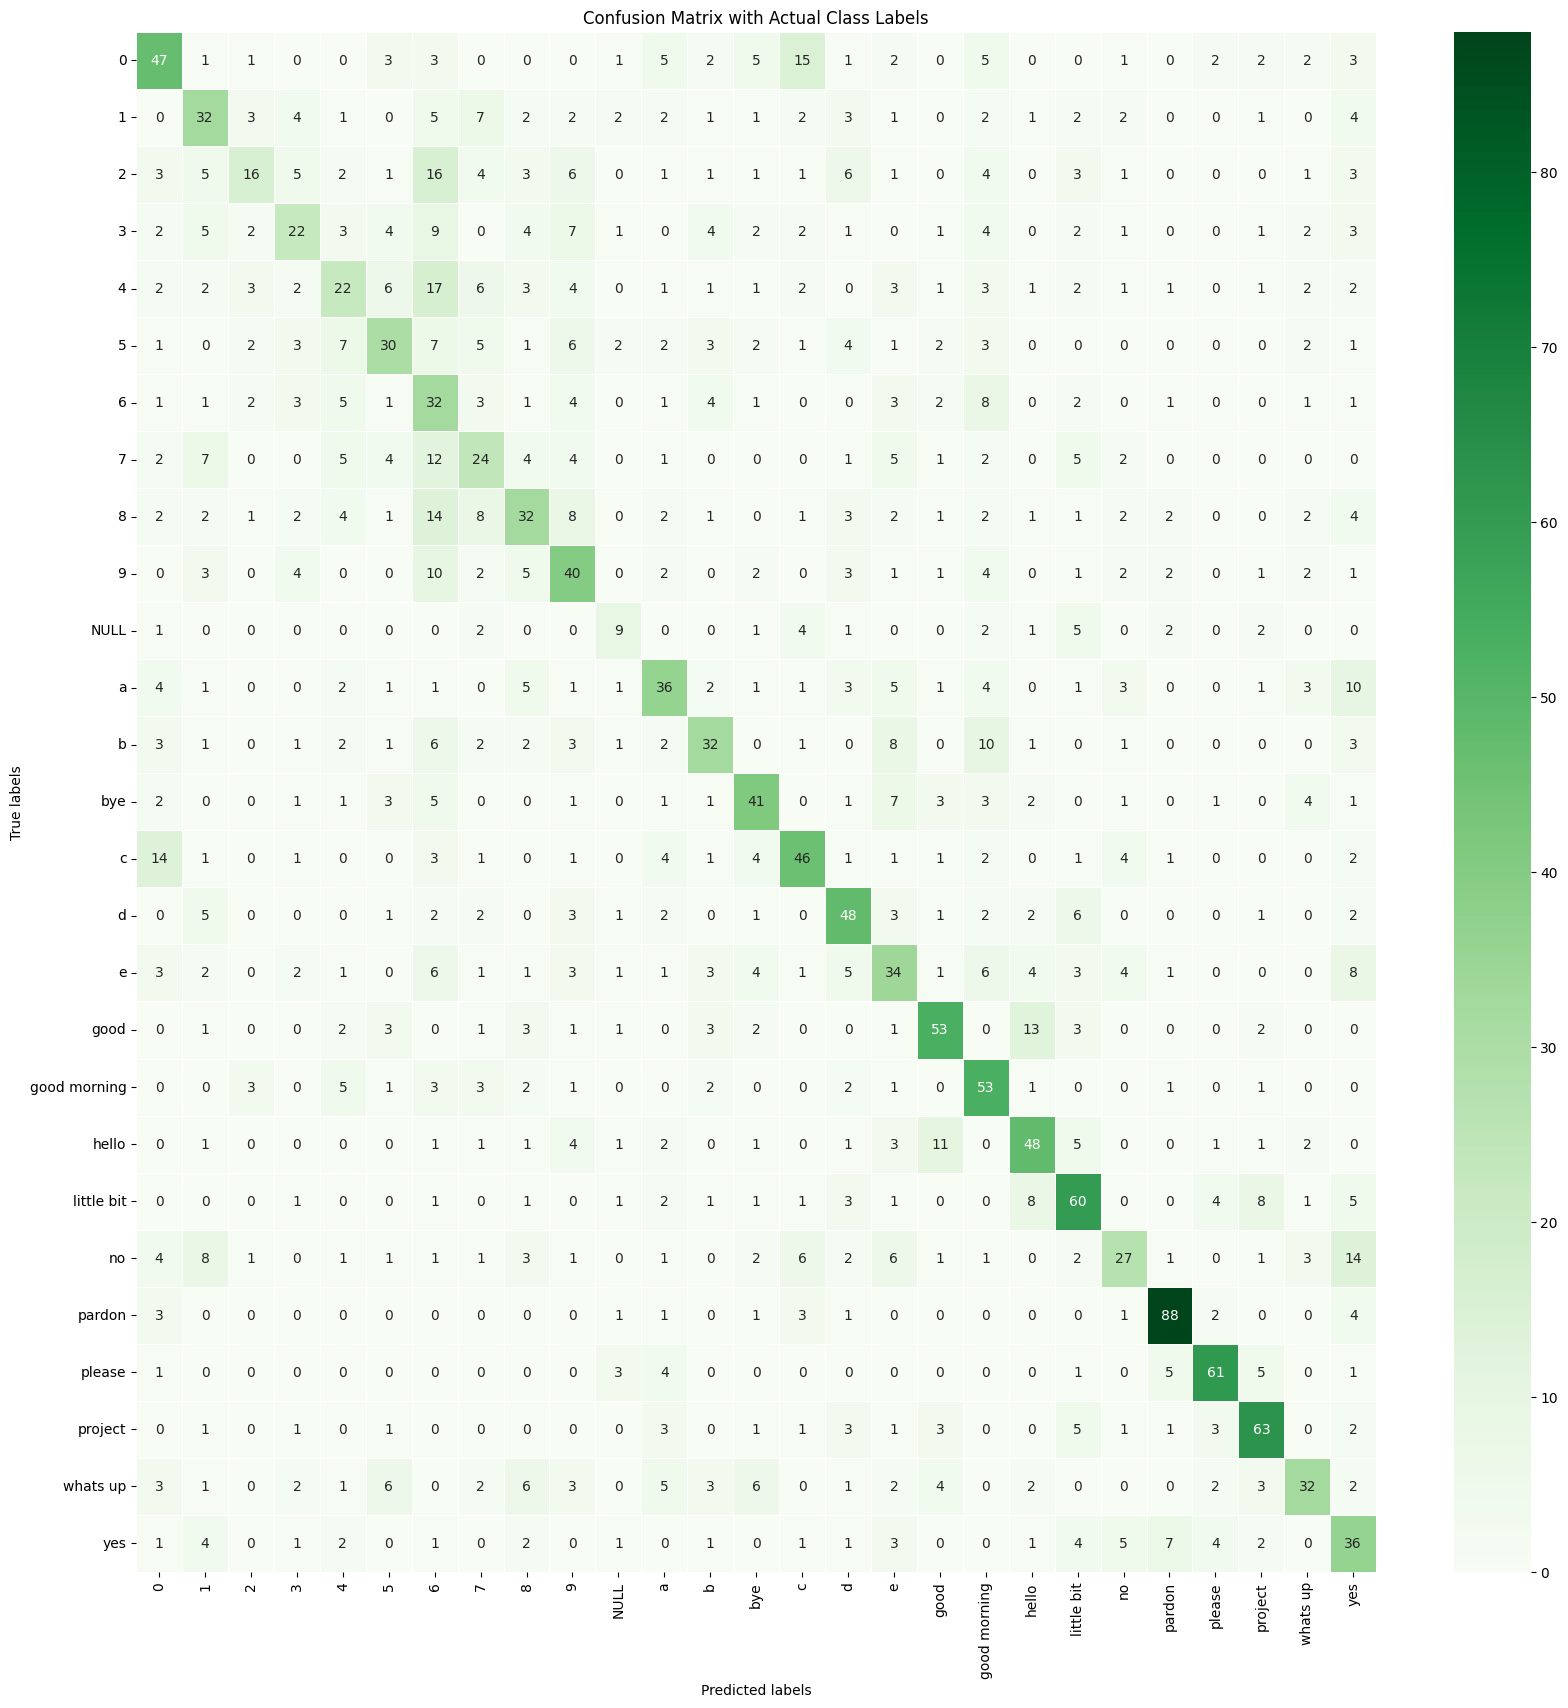


########### Final Results ###########
Validation Accuracy: 47.78508771929825
Test Accuracy: 46.64620780359491


In [8]:
hidden_layer_size = 500
learning_rate = 1e-3
num_classes = len(class_names)

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * width  * height, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, num_classes),
)

model = model.to(device=device)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

val_accs, train_accs, test_acc, losses = train_part(model, optimizer,epochs=10, return_acc=True, check_train_set = True, check_test_set = True)


# Print the validation and test accuracies
print()
print('########### Final Results ###########')
print("Validation Accuracy:", val_accs[-1])
print("Test Accuracy:", test_acc)

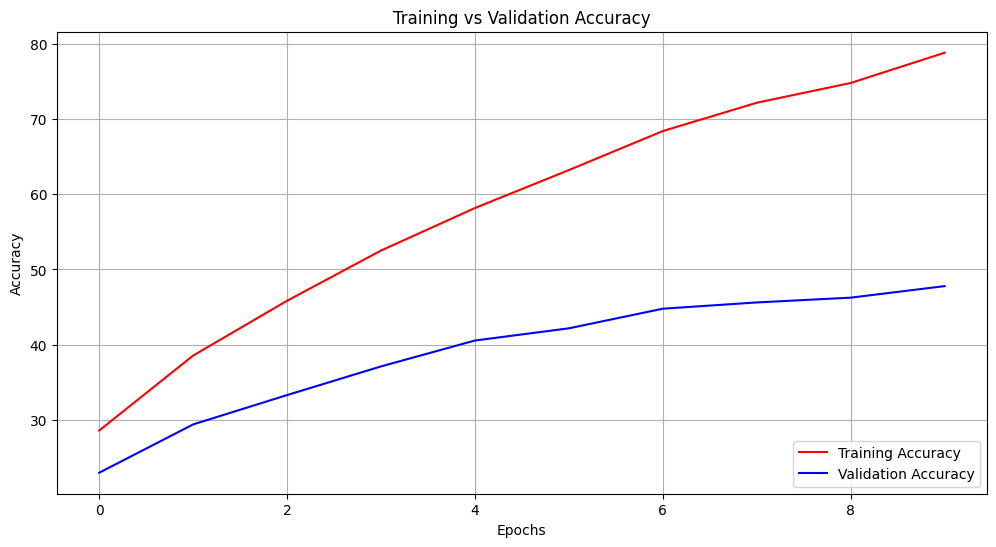

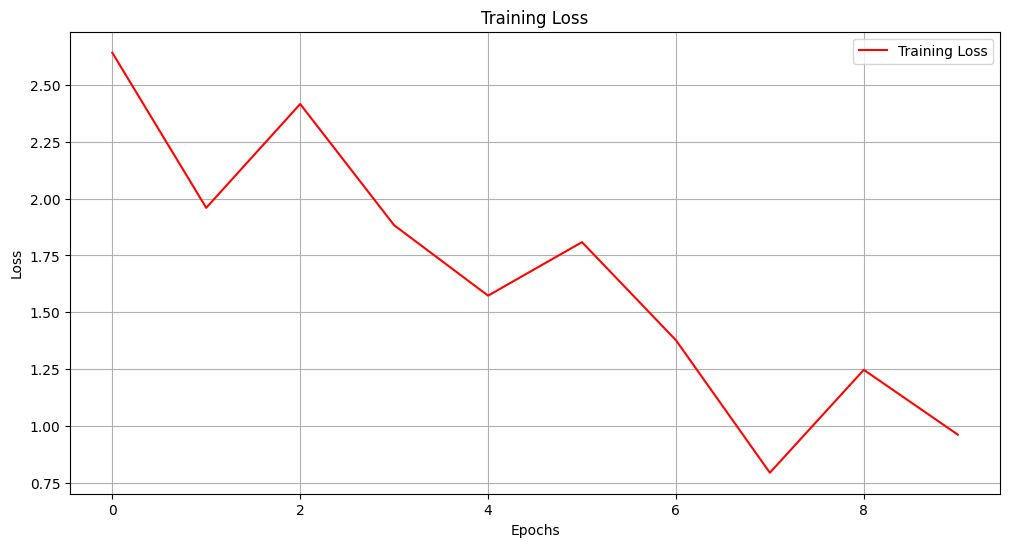

In [9]:
# Plot accuracy
epochs = range(len(val_accs))
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accs, 'r', label='Training Accuracy')
plt.plot(epochs, val_accs, 'b', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, losses, 'r', label='Training Loss')
#plt.plot(epochs, val_loss, 'b', label='Validation Loss')
#plt.title('Training vs Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()